<img src="./Images/Hack.png" alt="HackaThon" height="1000" width="1000"/>



<img src="./Images/investing-in-robotics-1.jpg" alt="HackaThon" height="700" width="700"/>

# *Test case* : _Currency Detector_

In [103]:
#!pip install tensorflow
#!pip install pillow
#!pip install numpy
#!pip install opencv-python

In [104]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt


In [105]:
graph_def = tf.compat.v1.GraphDef()
labels = []

In [106]:
type(labels)

list

In [107]:
filename = "model.pb"
labels_filename = "labels.txt"

In [108]:
# Import the TF graph
with tf.io.gfile.GFile(filename, 'rb') as f:
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

In [109]:
# Create a list of labels.
with open(labels_filename, 'rt') as lf:
    for l in lf:
        labels.append(l.strip())

In [110]:
print(labels)

['10', '100', '20', '200', '2000', '50', '500']


In [111]:
from PIL import Image
import numpy as np
import cv2

In [112]:
# Load from a file
image = cv2.imread('test8.jpg')

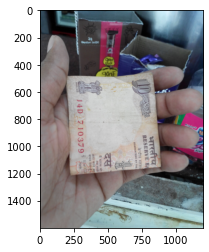

In [113]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [114]:
(h, w) = image.shape[:2]

In [115]:
(h, w)

(1600, 1200)

In [116]:
def convert_to_opencv(image):
    # RGB -> BGR conversion is performed as well.
    image = image.convert('RGB')
    r,g,b = np.array(image).T
    opencv_image = np.array([b,g,r]).transpose()
    return opencv_image

def crop_center(img,cropx,cropy):
    h, w = img.shape[:2]
    startx = w//2-(cropx//2)
    starty = h//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx]

def resize_down_to_1600_max_dim(image):
    h, w = image.shape[:2]
    if (h < 1600 and w < 1600):
        return image

    new_size = (1600 * w // h, 1600) if (h > w) else (1600, 1600 * h // w)
    return cv2.resize(image, new_size, interpolation = cv2.INTER_LINEAR)

def resize_to_256_square(image):
    h, w = image.shape[:2]
    return cv2.resize(image, (256, 256), interpolation = cv2.INTER_LINEAR)

def update_orientation(image):
    exif_orientation_tag = 0x0112
    if hasattr(image, '_getexif'):
        exif = image._getexif()
        if (exif != None and exif_orientation_tag in exif):
            orientation = exif.get(exif_orientation_tag, 1)
            # orientation is 1 based, shift to zero based and flip/transpose based on 0-based values
            orientation -= 1
            if orientation >= 4:
                image = image.transpose(Image.TRANSPOSE)
            if orientation == 2 or orientation == 3 or orientation == 6 or orientation == 7:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
            if orientation == 1 or orientation == 2 or orientation == 5 or orientation == 6:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

In [117]:
min_dim = min(w,h)
max_square_image = crop_center(image, min_dim, min_dim)

In [118]:
print(max_square_image)

[[[ 67  62  63]
  [ 66  61  62]
  [ 65  60  61]
  ...
  [110  85  59]
  [110  85  59]
  [110  85  59]]

 [[ 71  65  66]
  [ 70  64  65]
  [ 69  63  64]
  ...
  [108  83  57]
  [108  83  57]
  [108  83  57]]

 [[ 71  65  66]
  [ 70  64  65]
  [ 69  63  64]
  ...
  [110  86  58]
  [109  85  57]
  [109  85  57]]

 ...

 [[113 115 123]
  [109 111 119]
  [109 111 119]
  ...
  [117 103  84]
  [104  92  74]
  [ 99  87  69]]

 [[112 114 122]
  [108 110 118]
  [107 109 117]
  ...
  [114 103  83]
  [105  93  75]
  [104  92  74]]

 [[108 110 118]
  [110 112 120]
  [111 113 121]
  ...
  [110  99  79]
  [101  91  73]
  [104  94  76]]]


In [119]:
print(min_dim)

1200


In [120]:
# Resize that square down to 256x256
augmented_image = resize_to_256_square(max_square_image)

In [121]:
print(augmented_image)

[[[ 69  63  64]
  [ 67  62  61]
  [ 66  62  61]
  ...
  [115  88  62]
  [114  87  60]
  [109  85  58]]

 [[ 68  63  63]
  [ 66  61  59]
  [ 65  59  56]
  ...
  [111  84  57]
  [109  82  55]
  [104  80  50]]

 [[ 62  58  58]
  [ 64  59  57]
  [ 63  57  52]
  ...
  [108  81  54]
  [108  80  53]
  [107  81  51]]

 ...

 [[110 113 121]
  [113 116 121]
  [110 113 118]
  ...
  [121 109  81]
  [120 109  79]
  [131 120  93]]

 [[110 112 120]
  [110 113 118]
  [110 112 118]
  ...
  [124 110  82]
  [139 127  99]
  [107  93  71]]

 [[108 111 119]
  [110 113 118]
  [111 114 120]
  ...
  [125 114  83]
  [132 121  94]
  [115 101  82]]]


In [122]:
# Get the input size of the model
with tf.compat.v1.Session() as sess:
    input_tensor_shape = sess.graph.get_tensor_by_name('Placeholder:0').shape.as_list()
network_input_size = input_tensor_shape[1]

# Crop the center for the specified network_input_Size
augmented_image = crop_center(augmented_image, network_input_size, network_input_size)

In [123]:
# These names are part of the model and cannot be changed.
output_layer = 'loss:0'
input_node = 'Placeholder:0'

with tf.compat.v1.Session() as sess:
    try:
        prob_tensor = sess.graph.get_tensor_by_name(output_layer)
        predictions = sess.run(prob_tensor, {input_node: [augmented_image] })
    except KeyError:
        print ("Couldn't find classification output layer: " + output_layer + ".")
        print ("Verify this a model exported from an Object Detection project.")
        exit(-1)

In [124]:
# Print the highest probability label
highest_probability_index = np.argmax(predictions)
print('This is ' + labels[highest_probability_index] + ' Rupee Note')
print(highest_probability_index)
print(predictions)


This is 10 Rupee Note
0
[[9.7552639e-01 2.3794632e-02 1.9721834e-04 4.7220069e-04 1.7923057e-06
  5.8784565e-07 7.2061212e-06]]


In [125]:
list1 = []

In [126]:
list1.append(labels[highest_probability_index])

In [127]:
list1

['10']

In [128]:
# Or you can print out all of the results mapping labels to probabilities.
label_index = 0
for p in predictions:
    truncated_probablity = np.float64(np.round(p,20))
    print (labels[label_index], truncated_probablity)
    label_index += 1

10 [9.75526392e-01 2.37946324e-02 1.97218338e-04 4.72200685e-04
 1.79230574e-06 5.87845648e-07 7.20612161e-06]


In [129]:
import speech_recognition as sr
from gtts import gTTS

In [130]:
str2 =''.join(list1)
str1 ='This is '
str3 = ' Rupees Note'

str = str1+str2+str3

In [131]:
str

'This is 10 Rupees Note'

In [132]:
language = 'en'

In [133]:
currency_output = gTTS(text=str, lang=language, slow=True)

In [134]:
currency_output.save("currency.mp3")

In [135]:
os.system('start currency.mp3')

0

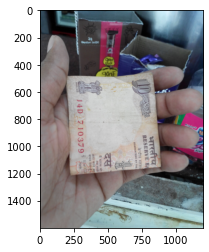

In [136]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))